This notebook performs hierarchical bootstraps and plots place field characteristics such as stability, reliability, field height, width, # fields, etc.

In [1]:
%load_ext autoreload
%autoreload 2
import sys
import platform
from pathlib import Path
from os import environ
if platform.system() == "Darwin": # Nat laptop
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/NeuroPy'])
    sys.path.extend(['/Users/nkinsky/Documents/UM/GitHub/sleep_deprivation/DataPaths/'])
    plot_dir = Path("/Users/nkinsky/Documents/UM/Working/Bapun_Data/plots")
else:
    if environ["HOSTNAME"] == "lnx00004": # Nat Linux computer
        sys.path.extend(['/data/GitHub/NeuroPy'])
        sys.path.extend(['/data/GitHub/sleep_loss_hippocampal_replay/analysis_and_figure_code/DataPaths'])
        plot_dir = Path('/data/Clustering/plots')
    else:  #BG computer
        sys.path.extend(['/home/nkinsky/Documents/GitHub/NeuroPy'])
        sys.path.extend(['/home/nkinsky/Documents/GitHubPrivate/pythonprogs/DataPaths/'])

group_data_dir = Path('/data/Clustering/grpdata')

import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
import scipy.signal as sg
import matplotlib.pyplot as plt
from neuropy.utils.mathutil import min_max_scaler
from scipy.ndimage import gaussian_filter1d, gaussian_filter
import pingouin as pg

from neuropy import plotting
from neuropy.core.epoch import Epoch
from neuropy.analyses.placefields import Pf1D, Pf1Dsplit
from neuropy.core.position import Position
from neuropy.plotting.ratemaps import plot_ratemap
from neuropy.plotting.figure import Fig
from neuropy.utils.misc import flatten

import subjects
from plotters import Plotter, get_nsd_vs_sd_df, add_parametric_extras, stats_to_df, filter_stats_df
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

/home/nkinsky/miniforge3/envs/NeuroPy/lib/python3.11/site-packages/outdated/utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.3, the latest is 0.5.5.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


## Define sessions

In [2]:
ntrials_dict = {"RatUDay2": [25, 17], "RatVDay1": [23, 30], "RatVDay3": [163, 103],
                "RatSDay3": [23, 16], "RatUDay1": [54, 4], "RatUDay4": [32, 4],
                "RatVDay2": [79, 92], "RatRDay2": [41, 10]}
sessions = subjects.remaze_sess()[1:]  # RatSDay2NSD does not have remaze position info

In [3]:
# Create combined colormap, use cmap3[0::2] to plot dark colors and cmap[1::2] to plot same colors but in light / pastel
cmap1 = sns.color_palette(as_cmap=True)
cmap2 = sns.color_palette("pastel", as_cmap=True)
cmap3 = []
for c1, c2 in zip(cmap1, cmap2):
    cmap3.extend([c1, c2])

## Load in group data

In [4]:
kw = dict(frate_thresh=0, grid_bin=5)  # Define placefield parameters
sigma2 = 1.5
height_thresh = 0.75
separate_run_dir = True

# Old, combined direction data with different speed and frate thresholds
# grp_savename = subjects.Group.basedir / f"placefield_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}.csv"

run_flag = "run_dir_separate" if separate_run_dir == True else "run_dir_combined"
grp_savename = group_data_dir / f"placefield_grp_stats.bin{kw['grid_bin']}.sigmabin{'_'.join(str(sigma2).split('.'))}.hthresh_{str(height_thresh).split('.')[1]}_{run_flag}.csv"
stats_all_df = pd.read_csv(grp_savename, index_col=0)
stats_all_df

,cell_id,peak_no,height,prominence,center_bin,width_bin,left_edge,right_edge,r_odd_even,r_maze_remaze,FRmax,FRmax_other_session,direction,session,animal,day,grp,sid
0,7,0,3.0,3.0,45.358242,3.513363,43.486637,NaN,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
1,7,1,0.7,0.5,35.953631,2.256332,34.801025,37.057357,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
2,7,2,0.5,0.5,3.570236,3.626780,1.742038,5.368818,-0.150833,-0.366868,3.092130,6.425988,up,MAZE,RatU,Day2,NSD,0
3,9,0,0.3,0.3,28.592451,2.961924,27.175557,30.137481,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
4,9,1,0.3,0.3,44.586341,5.730577,41.269423,NaN,NaN,0.012171,0.392076,4.165187,up,MAZE,RatU,Day2,NSD,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5204,55,5,1.1,1.1,59.000000,2.262388,57.868831,60.131219,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5205,55,6,0.4,0.4,67.000000,2.974970,65.512044,68.487014,0.641789,0.277849,3.793715,8.185448,down,reMAZE,RatR,Day2,SD,7
5206,59,0,0.7,0.7,51.000000,2.395026,49.802487,52.197513,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7
5207,59,1,0.5,0.5,27.000000,2.793090,25.603455,28.396545,NaN,0.392033,0.683997,0.377219,down,reMAZE,RatR,Day2,SD,7


## Reliability and stability


### Bootstrap reliability and stability

In [5]:
stats_all_peak = stats_all_df[stats_all_df.peak_no == 0]
df_rs = stats_all_df.pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                 columns="session", 
                                 values="r_odd_even").reset_index().drop(columns=["cell_id", "direction"]).reset_index()
df_rs.rename(columns={"sid": "session"})

session,index,grp,session,MAZE,reMAZE
0,0,NSD,0,-0.142335,0.951700
1,1,NSD,0,-0.150833,0.617885
2,2,NSD,0,0.040590,NaN
3,3,NSD,0,0.747352,0.854094
4,4,NSD,0,0.629554,0.865368
...,...,...,...,...,...
859,859,SD,7,0.864541,0.478741
860,860,SD,7,0.303631,0.280133
861,861,SD,7,0.681525,0.367422
862,862,SD,7,0.764482,-0.112693


In [6]:
from stats_utils import bootstrap_resample
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean(numeric_only=True).reset_index()
df_bs_all = []
for metric, sesh_type_drop, sesh_type_keep in zip(["r_odd_even", "r_maze_remaze"], ["reMAZE", "MAZE"],
                                                  ["MAZE", "NA"]):
    print(metric)
    df_use = stats_all_peak.pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                        columns="session", 
                                        values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})
    
    # if metric == "r_maze_remaze":
    #     df_use = df_use.drop(columns="reMAZE")
    df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
    df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
    df_bs["metric"] = metric
    df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
    df_bs_all.append(df_bs)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_stability_reliability_bootstrap.csv")
df_bs

r_odd_even
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 351.25it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:37<00:00, 263.28it/s]


r_maze_remaze
Running bootstraps for NSD group


100%|████████████████████████████████████| 10000/10000 [00:28<00:00, 350.66it/s]


Running bootstraps for SD group


100%|████████████████████████████████████| 10000/10000 [00:37<00:00, 264.31it/s]


,grp,session,r_odd_even,metric,r_maze_remaze
0,NSD,MAZE,0.569738,r_odd_even,NaN
1,NSD,MAZE,0.571981,r_odd_even,NaN
2,NSD,MAZE,0.646222,r_odd_even,NaN
3,NSD,MAZE,0.544581,r_odd_even,NaN
4,NSD,MAZE,0.419678,r_odd_even,NaN
...,...,...,...,...,...
59995,SD,MAZE,NaN,r_maze_remaze,0.332558
59996,SD,MAZE,NaN,r_maze_remaze,0.250771
59997,SD,MAZE,NaN,r_maze_remaze,0.262243
59998,SD,MAZE,NaN,r_maze_remaze,0.307014


### Plot reliability and stability

/tmp/ipykernel_3412544/1831255504.py:12: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.boxplot(data=df_bs, y="r_maze_remaze", hue="grp", whis=(2.5, 97.5), showfliers=False, legend=False, palette=cmap3[::2], ax=ax)
/tmp/ipykernel_3412544/1831255504.py:13: UserWarning: The palette list has more values (10) than needed (2), which may not be intended.
  sns.stripplot(data=df2_mean, y="r_maze_remaze", hue="grp", edgecolor="w", dodge=True, linewidth=0.5, palette=cmap3[::2], legend=False, ax=ax)
/tmp/ipykernel_3412544/1831255504.py:39: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.boxplot(data=df_grp, y="r_odd_even", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False,
/tmp/ipykernel_3412544/1831255504.py:41: UserWarning: The palette list has more values (20) than needed (2), which may not be intended.
  sns.stripplot(data=df2_mean[df2_mean.grp == grp], y="r_odd_even", hue

0
1


/tmp/ipykernel_3412544/1831255504.py:39: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.boxplot(data=df_grp, y="r_odd_even", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False,
/tmp/ipykernel_3412544/1831255504.py:41: UserWarning: The palette list has more values (18) than needed (2), which may not be intended.
  sns.stripplot(data=df2_mean[df2_mean.grp == grp], y="r_odd_even", hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,


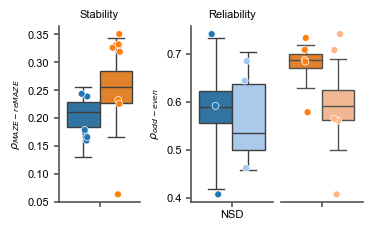

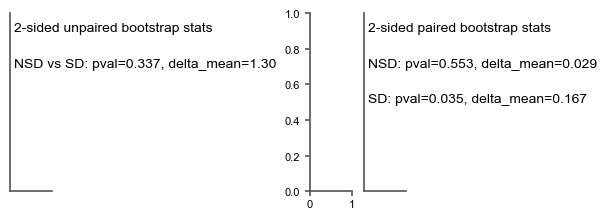

In [9]:
from stats_utils import get_bootstrap_prob, get_bootstrap_prob_paired
# fig, axs = plt.subplots(2, 3, figsize=(6, 8))
fig = plotting.Fig(12, 9)
figs = plotting.Fig(12, 9)

df2_mean = stats_all_peak.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# Stability NSD vs. SD
# ax, axstat = axs.T[0]
ax = fig.subplot(fig.gs[0:2, 0])
axstat = figs.subplot(figs.gs[2:4, 0])
sns.boxplot(data=df_bs, y="r_maze_remaze", hue="grp", whis=(2.5, 97.5), showfliers=False, legend=False, palette=cmap3[::2], ax=ax)
sns.stripplot(data=df2_mean, y="r_maze_remaze", hue="grp", edgecolor="w", dodge=True, linewidth=0.5, palette=cmap3[::2], legend=False, ax=ax)
ax.set_title("Stability")
ax.set_ylabel(r"$\rho_{MAZE-reMAZE}$")
sns.despine(ax=ax)
# ax.set_title(nname)
# ax.set_ylabel("Mean FR (Hz)")
# ax.set_xlabel("")

axstat.text(0.1, 0.9, "2-sided unpaired bootstrap stats")
sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == "r_maze_remaze"]
dmean, pval = get_bootstrap_prob(df_trim[df_trim.grp == "NSD"]["r_maze_remaze"], df_trim[df_trim.grp == "SD"]["r_maze_remaze"])
axstat.text(0.1, yt, f"NSD vs SD: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
axstat.set_xticks([])
axstat.set_yticks([])

# Reliability NSD vs. SD
ax, axstat = axs.T[1]

# for ida, (axuse, grp) in enumerate(zip(axs.T[1:], ["NSD", "SD"])):
for ida, grp in enumerate(["NSD", "SD"]):
    # ax, axstat = axuse
    ax = fig.subplot(fig.gs[0:2, ida + 1])
    axstat = figs.subplot(figs.gs[2:4, ida + 1])
    df_grp = df_bs[df_bs.grp == grp]
    sns.boxplot(data=df_grp, y="r_odd_even", hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
                palette=cmap3[ida*2:], ax=ax)
    sns.stripplot(data=df2_mean[df2_mean.grp == grp], y="r_odd_even", hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
                  palette=cmap3[ida*2:], ax=ax)
    print(ida)
    if ida == 0:
        ax.set_title("Reliability")
        ax.set_ylabel(r"$\rho_{odd-even}$")
        ax.set_xticklabels([grp])
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
yt = 0.7
df_trim = df_bs[df_bs.metric == "r_odd_even"]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"]["r_odd_even"], 
                                            df_grp[df_grp.session == "reMAZE"]["r_odd_even"])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.3f}")
    yt -= 0.2
    
[sns.despine(ax=a, left=True, bottom=True) for a in axs[1]];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1, 1].set_axis_off()
axs[0, 1].set_ylim(axs[0, 2].get_ylim())

fig.savefig(plot_dir / "PF_stability_reliability_bs.pdf")

## Peak Firing Rate

In [ ]:
from copy import deepcopy
def trim_unreliable_neurons(df_in):
    """Trims out neurons that aren't active in BOTH MAZE and reMAZE"""

    df_trim_comb = []
    for animal in df_in.animal.unique():
        df_animal = df_in[df_in.animal == animal]
        for day in df_animal.day.unique():
            df_use = df_animal[df_animal.day == day]
            maze_ids = df_use[df_use.session == "reMAZE"].cell_id.unique()
            remaze_ids = df_use[df_use.session == "MAZE"].cell_id.unique()
            maze_same = [np.isin(mid, remaze_ids) for mid in maze_ids]
            same_ids = maze_ids[maze_same]

            df_trim_temp = deepcopy(df_use)
            df_trim_comb.append(df_trim_temp[np.isin(df_trim_temp.cell_id, same_ids)])

    return pd.concat(df_trim_comb, axis=0, ignore_index=True)

df_use = trim_unreliable_neurons(stats_all_df[stats_all_df.grp == "NSD"])
df_use

### Peak field bootstrap

In [ ]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
metric = "height"
df_use = trim_unreliable_neurons(stats_all_peak).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_FRpeak_peak_field.csv")
df_bs

### Peak field Plot

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(6, 8))
metric, mname = "height", "Primary Peak FR (Hz)"

df2_mean = stats_all_peak.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

axs[0, 0].set_axis_off()

# NSD vs SD
ax, axstat = axs.T[1]
for ida, (axuse, grp) in enumerate(zip(axs.T[1:], ["NSD", "SD"])):
    ax, axstat = axuse
    df_grp = df_bs[df_bs.grp == grp]
    sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
                palette=cmap3[ida*2:], ax=ax)
    sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
                  palette=cmap3[ida*2:], ax=ax)

    if ida == 0:
        ax.set_ylabel(mname)
        ax.set_xticklabels([grp])
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
# sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs[1]];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1, 1].set_axis_off()
axs[0, 1].set_ylim(axs[0, 2].get_ylim())

fig.savefig(plot_dir / "PF_peakFR_bs.pdf")

#### 2ndary field FR bootstrap

In [ ]:
stats_all_peak2 = stats_all_df[stats_all_df.peak_no == 1]

In [ ]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean(numeric_only=True).reset_index()
df_bs_all = []
metric = "height"
df_use = trim_unreliable_neurons(stats_all_peak2).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_FRpeak_secondary_field.csv")
df_bs

#### 2ndary field plot

In [ ]:
fig, axs = plt.subplots(2, 3, figsize=(6, 8))
metric, mname = "height", "2ndary Peak FR (Hz)"

axs[0, 0].set_axis_off()

df2_mean = stats_all_peak2.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# NSD vs SD
ax, axstat = axs.T[1]
for ida, (axuse, grp) in enumerate(zip(axs.T[1:], ["NSD", "SD"])):
    ax, axstat = axuse
    df_grp = df_bs[df_bs.grp == grp]
    sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
                palette=cmap3[ida*2:], ax=ax)
    sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
                  palette=cmap3[ida*2:], ax=ax)
    if ida == 0:
        ax.set_ylabel(mname)
        ax.set_xticklabels([grp])
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)
    

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
# sns.despine(ax=ax)
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs[1]];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1, 1].set_axis_off()
axs[0, 1].set_ylim(axs[0, 2].get_ylim())

fig.savefig(plot_dir / "PF_peakFR_2ndary_bs.pdf")

## # Fields

### Bootstrap # fields

In [ ]:
# Calculate # fields
fields_keep = ["grp", "sid", "session", "animal", "day", "direction", "cell_id"]
nfields_df = stats_all_df.groupby(fields_keep).count().reset_index().drop(columns=stats_all_df.columns[~np.isin(stats_all_df.columns, fields_keep)][1:])
nfields_df = nfields_df.rename(columns={"peak_no": "# fields"})
nfields_df


In [ ]:
func = lambda df: df.drop(["session"], axis=1).groupby(["grp"]).mean().reset_index()
df_bs_all = []
metric = "# fields"
df_use = trim_unreliable_neurons(nfields_df).pivot_table(index=["grp", "sid", "cell_id", "direction"], 
                                  columns="session", 
                                  values=metric).reset_index().drop(columns=["cell_id", "direction"]).reset_index().rename(columns={"sid": "session"})

df_bs = bootstrap_resample(df_use, level="both", n_iter=10000, apply=func)
df_bs = pd.melt(df_bs, id_vars=["grp"], value_vars=["MAZE", "reMAZE"], var_name="session", value_name=metric, ignore_index=False)
df_bs["metric"] = metric
df_bs = df_bs[~((df_bs.metric == "r_maze_remaze") & (df_bs.session == "reMAZE"))]  # drop extra maze_v_remaze corrs
df_bs_all.append(df_bs)

_, ax = plt.subplots()
sns.boxplot(data=df_bs, x="grp", y=metric, hue="session", ax=ax)

df_bs = pd.concat(df_bs_all, axis=0, ignore_index=True)
df_bs.to_csv(group_data_dir / "pf_nfields_bs.csv")
df_bs

### Plot # fields

In [ ]:
from neuropy.utils.plot_util import match_axis_lims
fig, axs = plt.subplots(2, 3, figsize=(6, 8))
metric, mname = "# fields", "# fields"

axs[0, 0].set_axis_off()

df2_mean = nfields_df.groupby(["grp", "session", "sid"]).mean(numeric_only=True).reset_index()

# NSD vs SD
ax, axstat = axs.T[1]
for ida, (axuse, grp) in enumerate(zip(axs.T[1:], ["NSD", "SD"])):
    ax, axstat = axuse
    df_grp = df_bs[df_bs.grp == grp]
    sns.boxplot(data=df_grp, y=metric, hue="session", whis=(2.5, 97.5), showfliers=False, legend=False, 
                palette=cmap3[ida*2:], ax=ax)
    sns.stripplot(data=df2_mean[df2_mean.grp == grp], y=metric, hue="session", dodge=True, edgecolor="w", linewidth=0.5, legend=False,
                  palette=cmap3[ida*2:], ax=ax)
    if ida == 0:
        ax.set_ylabel(mname)
        ax.set_xticklabels([grp])
        sns.despine(ax=ax)
    elif ida == 1:
        ax.set_ylabel("")
        ax.set_yticks([])
        sns.despine(ax=ax, left=True, bottom=False)

axstat.text(0.1, 0.9, "2-sided paired bootstrap stats")
yt = 0.7
df_trim = df_bs[df_bs.metric == metric]
for grp in ["NSD", "SD"]:
    df_grp = df_trim[df_trim.grp == grp]
    dmean, pval = get_bootstrap_prob_paired(df_grp[df_grp.session == "MAZE"][metric], 
                                            df_grp[df_grp.session == "reMAZE"][metric])
    axstat.text(0.1, yt, f"{grp}: pval={pval*2:0.3f}, delta_mean={dmean:0.2f}")
    yt -= 0.2
[sns.despine(ax=a, left=True, bottom=True) for a in axs[1]];
axstat.set_xticks([])
axstat.set_yticks([])

axs[1, 1].set_axis_off()
match_axis_lims(axs[0, 1:], "y")

fig.savefig(plot_dir / "PF_nfields_bs.pdf")

## NRK TODO
Run # fields analysis with a better threshold, e.g. # peaks above a certain firing rate or within 50% of the peak FR?  Look at literature to determine # fields.